<a href="https://colab.research.google.com/github/MilenaHristova/LearningMachineLearning/blob/master/BloodCells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys

ROOT_DIR = "/content/drive/My Drive/Blood Cells/"

mrcnn_path = os.path.join(ROOT_DIR, "mrcnn")
sys.path.append(mrcnn_path)
sys.path.append(ROOT_DIR)

import visualize
import utils
from visualize import display_images
import model as modellib
from model import log

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir(ROOT_DIR) 
!unzip "train.zip"

Archive:  train.zip
   creating: train/
   creating: train/img/
  inflating: train/img/BloodImage_00001.jpg  
  inflating: train/img/BloodImage_00003.jpg  
  inflating: train/img/BloodImage_00004.jpg  
  inflating: train/img/BloodImage_00005.jpg  
  inflating: train/img/BloodImage_00006.jpg  
  inflating: train/img/BloodImage_00008.jpg  
  inflating: train/img/BloodImage_00009.jpg  
  inflating: train/img/BloodImage_00010.jpg  
  inflating: train/img/BloodImage_00012.jpg  
  inflating: train/img/BloodImage_00013.jpg  
  inflating: train/img/BloodImage_00020.jpg  
  inflating: train/img/BloodImage_00022.jpg  
  inflating: train/img/BloodImage_00023.jpg  
  inflating: train/img/BloodImage_00024.jpg  
  inflating: train/img/BloodImage_00026.jpg  
  inflating: train/img/BloodImage_00032.jpg  
  inflating: train/img/BloodImage_00034.jpg  
  inflating: train/img/BloodImage_00036.jpg  
  inflating: train/img/BloodImage_00038.jpg  
  inflating: train/img/BloodImage_00039.jpg  
  inflating: tra

In [0]:
from mrcnn.config import Config
import skimage.io
from imgaug import augmenters as iaa

In [0]:
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
RESULTS_DIR = os.path.join(ROOT_DIR, "results/bloodcells/")
TRAIN_DIR = os.path.join(ROOT_DIR, "train/img/")
VAL_DIR = os.path.join(ROOT_DIR,"val/img/")

TRAIN_IMAGE_IDS = os.listdir(TRAIN_DIR)
VAL_IMAGE_IDS = os.listdir(VAL_DIR)
TrainCount = len(TRAIN_IMAGE_IDS)

class BloodConfig(Config):
    NAME = "blood"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = (TrainCount - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 512


In [0]:
config = BloodConfig()

In [0]:
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
model = modellib.MaskRCNN(mode="training",
                              model_dir=LOGS_DIR,
                              config=config)

W0826 12:35:02.235184 140418195793792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 12:35:02.289047 140418195793792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 12:35:02.315783 140418195793792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 12:35:02.351239 140418195793792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0826 12:35:02.355881 140418195

In [0]:
import numpy as np
TRAIN_DIR = os.path.join(ROOT_DIR, "train/img/")
VAL_DIR = os.path.join(ROOT_DIR, "val/img/")
TRAIN_IMAGE_IDS = os.listdir(TRAIN_DIR)
VAL_IMAGE_IDS = os.listdir(VAL_DIR)

class BloodDataset(utils.Dataset):
    def load_images(self, dataset_dir, subset):
        self.add_class("blood", 1, "cell")
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset + "/img")
        for filename in os.listdir(dataset_dir):
            image_path = os.path.join(dataset_dir, filename)
            image = skimage.io.imread(image_path)
            filename, file_extension = os.path.splitext(filename)
            self.add_image(
                "blood",
                image_id=filename,
                path=image_path,
                subset = subset)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        image_path = info['path']
        if(info['subset'] == 'train'):
          masks_path = os.path.join(ROOT_DIR, "train/masks_machine")
        else: masks_path = os.path.join(ROOT_DIR, "val/masks_machine")
        filename = image_path.split('/')[-1]
        filename, file_extension = os.path.splitext(filename)
        mask_path = masks_path + "/" + filename + ".png"
        
        #mask_path = masks_path + "/" +  str(image_id) + ".png";
       # mask_path = os.path.join(masks_path, image_id+".png")
        mask_img = skimage.io.imread(mask_path)
        mask = np.asarray(mask_img)
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "blood":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [0]:
import imgaug
from imgaug import augmenters as iaa

augmentation = iaa.SomeOf((0,4), [
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.2*255),
    iaa.Add(50, per_channel=True),
    iaa.Sharpen(alpha=0.5)
])

In [0]:
DATASET_DIR = "/content/drive/My Drive/Blood Cells/"
dataset_train = BloodDataset()
dataset_train.load_images(DATASET_DIR, "train")
dataset_train.prepare()

dataset_val = BloodDataset()
dataset_val.load_images(DATASET_DIR, "val")
dataset_val.prepare()


In [0]:
COCO_PATH = "/content/drive/My Drive/Blood Cells/mask_rcnn_coco.h5"

model.load_weights(COCO_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])


In [0]:
print("Training network heads")

model.train(dataset_train, dataset_val,
     learning_rate=config.LEARNING_RATE,
     epochs=30,
     layers='heads',
     augmentation = augmentation)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Blood Cells/logs/blood20190826T1235/mask_rcnn_blood_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4

W0826 12:35:54.046879 140418195793792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/30
191/191 [==============================] - 97s 510ms/step - loss: 1.0970 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.5607 - val_loss: 0.5807 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.0292 - val_mrcnn_class_loss: 0.0120 - val_mrcnn_bbox_loss: 0.0916 - val_mrcnn_mask_loss: 0.4429
Epoch 2/30
191/191 [==============================] - 54s 282ms/step - loss: 0.7250 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.4472 - val_loss: 0.6732 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.0863 - val_mrcnn_class_loss: 0.0059 - val_mrcnn_bbox_loss: 0.1902 - val_mrcnn_mask_loss: 0.3898
Epoch 3/30
191/191 [==============================] - 53s 279ms/step - loss: 0.6745 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.3886 - val_loss: 0.5661 - val_rpn_c

In [0]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=40, 
            layers="all")


Starting at epoch 32. LR=0.001

Checkpoint Path: /content/drive/My Drive/Blood Cells/logs/blood20190826T1235/mask_rcnn_blood_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 33/40
191/191 [==============================] - 100s 522ms/step - loss: 0.2965 - rpn_class_loss: 7.7293e-04 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.2091 - val_loss: 0.2293 - val_rpn_class_loss: 3.2904e-04 - val_rpn_bbox_loss: 0.0043 - val_mrcnn_class_loss: 0.0019 - val_mrcnn_bbox_loss: 0.0037 - val_mrcnn_mask_loss: 0.2191
Epoch 34/40
191/191 [==============================] - 70s 369ms/step - loss: 0.2553 - rpn_class_loss: 8.2007e-04 - rpn_bbox_loss: 0.0177 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.2163 - val_loss: 0.3775 - val_rpn_class_loss: 2.4098e-04 - val_rpn_bbox_loss: 0.1506 - val_mrcnn_class_loss: 0.0027 - val_mrcnn_bbox_loss: 0.0056 - val_mrcnn_mask_loss: 0.2184
Epoch 35/40
191/191 [==============================] - 70s 367ms/step - loss: 0.2415 - rpn_class_loss: 6.3224e-04 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.2027 - val_

In [0]:
class InferenceConfig(BloodConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0

inference_config = InferenceConfig()

In [0]:
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=inference_config)

W0826 13:18:02.928798 140418195793792 deprecation_wrapper.py:119] From /content/drive/My Drive/Blood Cells/mrcnn/model.py:758: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0826 13:18:02.947613 140418195793792 deprecation.py:323] From /content/drive/My Drive/Blood Cells/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [0]:
weights_path = model.find_last()
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 40


In [0]:
model.save_weights(LOGS_DIR)

AttributeError: ignored

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [0]:
DATASET_DIR = "/content/drive/My Drive/Blood Cells/"
dataset = BloodDataset()
dataset.load_images(DATASET_DIR, "train")
dataset.prepare()


image ID: blood.BloodImage_00095 (48) /content/drive/My Drive/Blood Cells/train/img/BloodImage_00095.jpg
Original image shape:  [480 640   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  234.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  234.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 3)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.333
AP @0.55:	 0.333
AP @0.60:	 0.333
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.5

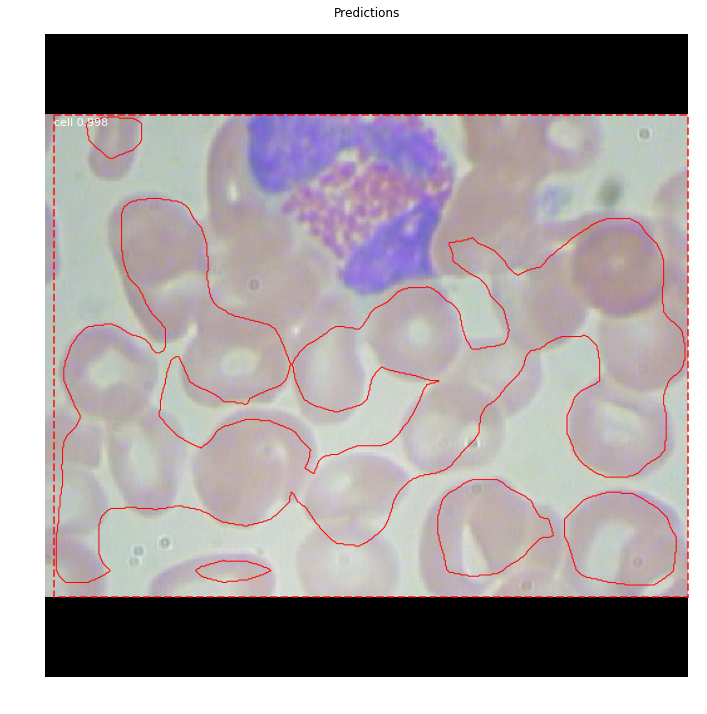

In [0]:
import random

image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                             dataset.class_names, r['scores'], ax=get_ax(1),
                             show_bbox=True, show_mask=False,
                             title="Predictions")

In [0]:
import mrcnn
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

TypeError: ignored

In [0]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

NameError: ignored